# Notebook setup

This notebook contains our most comprehensive parsing and analysis flow. Some of our failed attempts or frivolous anaylses have been removed for clarity.

In [8]:
import pandas as pd
import pickle
import pathlib
import datetime
from os import listdir
from os.path import isfile, join
import matplotlib
import matplotlib.pyplot as plt
from fuzzywuzzy import fuzz
import numpy as np
import seaborn as sns
import math
import re
import json
import cv2
import matplotlib.pyplot as plt
import cvlib as cv
from cvlib.object_detection import draw_bbox
import urllib.request
import requests
from colorthief import ColorThief
import sys
import io
from io import StringIO
import cv2
import os
from collections import defaultdict
import math
from fuzzywuzzy import fuzz
import matplotlib.style as style
from shutil import copyfile
from IPython.core.display import display, HTML
from colorutils import Color
from PIL import ImageColor
import colorsys

In [ ]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

## Load saved data if it exists

In [294]:
df_mfa = pd.read_pickle('df_mfa.pkl')
df_instagram = pd.read_pickle('df_instagram.pkl')

## Import collection data

The collection data is split into fragments because we had to scrape the MFA collection multiple times to collect missing fragments. We hopped through free proxies during scraping and many of them were invalid. We ran multiple scrapes, each one scraping works that had fallen through the cracks of the previous scrape until we had the entire dataset.

In [172]:
# load all collection data
df = pd.read_pickle('../scraper/mfaboston_collection.pkl')
df_missing = pd.read_pickle('../scraper/mfaboston_collection-missing.pkl')
df_missing_3 = pd.read_pickle('../scraper/mfaboston_collection-missing-3.pkl')
df_missing_4 = pd.read_pickle('../scraper/mfaboston_collection-missing-4.pkl')
df_missing_5 = pd.read_pickle('../scraper/mfaboston_collection-missing-5.pkl')
df_missing_6 = pd.read_pickle('../scraper/mfaboston_collection-missing-6.pkl')
df_missing_7 = pd.read_pickle('../scraper/mfaboston_collection-missing-7.pkl')
df_missing_8 = pd.read_pickle('../scraper/mfaboston_collection-missing-8.pkl')
df_missing_9 = pd.read_pickle('../scraper/mfaboston_collection-missing-9.pkl')
df_missing_10 = pd.read_pickle('../scraper/mfaboston_collection-missing-10.pkl')

# merge all scrapes into single dataframe
df_merged = pd.concat([df,df_missing, df_missing_3, df_missing_4, df_missing_5,df_missing_6, df_missing_7,df_missing_8,df_missing_9,df_missing_10])
df_merged = df_merged.drop_duplicates(subset='id', keep="last")
df_merged = df_merged.replace('\n','', regex=True)
df_merged = df_merged[df_merged['title'].notnull()]
df_merged['onview'] = df_merged['onview'].apply(lambda x: x[0] if x else None)

# save ids of any works where data is null-- these will need to be scraped again
missing_ids = df_merged[df_merged['title'].isnull()]['id']
with open('../scraper/object_ids.pkl', 'wb') as f:
    pickle.dump(missing_ids, f)

## Load Instagram data

In [6]:
# import Instagram posts data JSON file created by "instaparser.py"
df_instagram = pd.read_json('../scraper/instagram_posts.json')
df_instagram = df_instagram.replace('\n','', regex=True)
df_instagram = df_instagram[df_instagram['text'].notnull()]
df_instagram['id'] = df_instagram['id'].astype(int)

# preview format
df_instagram.head(2).T

,0,1,2,3,5
text,"#Renaissance painter Fra Filippo Lippi inspired his star student #Botticelli with majestic, intimate depictions of the Virgin and Child. The back of this panel on view in “Botticelli and the Search for the Divine” reveals rare examples of Lippi’s draftsmanship. #mfaBotticelliPictured: “Virgin and Child,” about 1466–69, on loan from Palazzo Medici Riccardi, Florence.",Enti 🌹🥀🌹Aquarelle 🖤 2021.Arches 10×14 140 lb. Cold Press.Watercolor with coffee and rose hookah tobacco.أُحِبُّكِ انتِ. 🥀❤🕊#yourdamascenerose 🥀🇸🇾#Syria #SaveSyria 💚🌹❤🌹🖤#Watercolor #Watercolour #Aquarelle #watercolorpainting #WatercolorArt #PaintersOfInstagram #Painting #Painter #Paint #tableaux #Drawing #Sketching #Dessiner #Dessin #ArtistsonInstagram #Art #InstaArt #Portraits #Beauty #Beautiful #SyrianBeauty 🥀🇸🇾 #Femme #ArtistsForPeace #PortraitPainting #MFABoston #MFABostonStudio #HeartArt ❤,Another day another walk. Is that a horse on my head? #boston #mfaboston,📖,😍 #mfa #claudemonet #mfaboston-@reginakuotw
date,2017-05-16 19:54:12,2021-02-14 22:36:28,2020-12-22 01:23:50,2020-02-18 21:55:50,2021-03-22 00:05:11
filename,2017-05-16_19-54-12_UTC.json.xz,2021-02-14_22-36-28_UTC.json 2.xz,2020-12-22_01-23-50_UTC.json.xz,2020-02-18_21-55-50_UTC.json.xz,2021-03-22_00-05-11_UTC.json.xz
id,1516194176857228288,2509218597353401344,2469440177853366272,2246829331534296064,2534630401824470016
shortcode,BUKmpIaF0Pw,CLSiQUXDasc,CJFNsITBv88,B8uV19xB7RG,CMs0OvhpzP8
comments_count,25.0,1.0,0.0,0.0,0.0
comments_disabled,0.0,0.0,0.0,0.0,0.0
taken_at_timestamp,1494964452.0,1613342188.0,1608600230.0,1582062950.0,1616371511.0
width,750.0,1080.0,1080.0,1080.0,1080.0
height,937.0,1334.0,1349.0,1080.0,607.0


## Filter unwanted posts

In [17]:
filter_intagram_ids = ['2443766684216227840' , '2468240716785932288', '2519193604305205248', '2443223434310818816', '2507781607335939584']
df_instagram = df_instagram[~df_instagram['id'].isin(filter_intagram_ids)]

## Save dataframes as pickles

In [ ]:
# Commented to prevent accidental overwrites, creating new features again takes a considerable amount of time

# df_mfa.to_pickle('df_mfa.pkl')
# df_instagram.to_pickle('df_instagram.pkl')

# Feature Engineering

## Hashtags

In [15]:
# create new hashtag-related features
def get_hashtags(text):
    text = text.split(' ')
    text = [t for t in text if len(t) > 0]
    text = [t for t in text if t[0] == '#']
    return text

def get_sans_hashtags(text):
    text = " ".join(filter(lambda x:x[0]!='#', text.split()))
    return text

df_instagram['hashtags'] = df_instagram['text'].apply(get_hashtags)
df_instagram['text_nohastags'] = df_instagram['text'].apply(get_sans_hashtags)

# preview
hashtags = list(df_instagram['hashtags'])
flat_list = [item for sublist in hashtags for item in sublist]
df_hashtags = pd.DataFrame(flat_list).rename(columns={0: 'hashtag'})
pd.DataFrame(df_hashtags['hashtag'].value_counts()).head(10)

## Artist name

In [13]:
def find_last_name(row):
    name = row.rstrip().lstrip().split(',')[0].split(' ')
    if len(name[-1]) == 1 and len(name) > 1:
        name = name[-2]
    else:
        name = name[-1]
    return name

# filter out names that aren't good, like "artist" and "unidentified"
def clean_last_name(row):
    name = row.lower()
    filter_names = ['artist', 'Manufactory']
    return name

def filter_words(name):
    if name == None:
        return None
    filter_terms = ['engraved by:', 'derived from:', 'based on:', 'retailer:', 'assayer:', 'gilder:', 'potter:', 'painter:', 'school:', '[role]:', 'probably workshop of:', 'workshop of:', 'factory of:', 'follower of:', 'circle of:', 'designer:', 'formerly known as:', 'probably painted', 'style of:', 'possibly in conjunction with:', 'partner:', 'manufacturer:', 'mark of:', 'mark ascribed to:', 'engraved with:', 'modeled by:','made for:', 'manufactured by:', 'publisher:', 'possibly after:', 'possibly:', 'possibly by:', 'copied after:', 'probably by:', 'maker:', 'designed and', 'designed by:', 'designed for:', 'designed and engraved by:', 'attributed to:', 'made by:', 'made at:', 'possibly by:', 'marked by:']
    for term in filter_terms:
        name = name.lower().replace(term.lower(), ' ')
    filter_terms = ['or:', 'by:', 'and:', 'after:', 'with:', 'of:']
    for term in filter_terms:
        name = name.lower().replace(term.lower(), ' ')
    return name

df_mfa['people'] = df_mfa['people'].str.lstrip()
df_mfa['people'] = df_mfa['people'].str.rstrip()
df_mfa['people'] = df_mfa['people'].apply(lambda x: x if x and x.find('Unidentified artist') == -1 else None) 
df_mfa['people'] = df_mfa['people'].apply(lambda x: x if x and x.find('Artist Unidentified') == -1 else None) 

df_mfa['clean_name'] = df_mfa['people'].apply(lambda s: re.sub("\((?:[^)(]|\([^)(]*\))*\)", "", s) if s else None) 
df_mfa['clean_name'] = df_mfa['clean_name'].apply(filter_words)
df_mfa['clean_name'] = df_mfa['clean_name'].str.lstrip()

0      charles e. barber   augustus saint-gaudens                 
2      None                                                       
3      kiki smith   universal limited art editions, inc., new york
4      None                                                       
5      None                                                       
       ...                                                        
138    john hull   robert sanderson, sr.                          
139    laurin hovey martin                                        
140    bernardo daddi                                             
142    None                                                       
145    charles eames   ray eames   evans products company         
Name: clean_name, Length: 4347, dtype: object

## Date created

In [14]:
def parse_dates(d):
    if d == None:
        return d
    is_negative = False
    if d.lower() in 'b.c.' or d.lower() in 'bc':
        is_negative = True
    dates = [str(s) for s in d.split() if s.isdigit()]
    if len(dates) == 0:
        return d
    # TODO: Negative (B.C.) not currently working
    if is_negative:
        dates = [f'-{d}' for d in dates]
    return dates

def parse_century(d):
    if d == None:
        return d
    if not any(char.isdigit() for char in d):
        return None
    is_negative = False
    if 'b.c' in d.lower() or 'bc' in d.lower():
        is_negative = True
    if 'th' in d.lower() or 'rd' in d.lower() or 'st' in d.lower() or 'nd' in d.lower():
        d = [t for t in d.split(' ') if t.endswith('th')]
        d = [int(t.replace('th','')) for t in d]
        d = [(t-1)*100 for t in d]
        if is_negative:
            d = [-t for t in d]
        return d
    dates = [int(s) for s in d.split() if s.isdigit()]
    if len(dates) == 0:
        return d
    # TODO: Negative (B.C.) not currently working
    if is_negative:
        dates = [-d for d in dates]
    return dates

df_mfa['parsedDates'] = df_mfa['displayDate'].apply(lambda d: d.replace('–', ' ') if d else d)
df_mfa['parsedDates'] = df_mfa['parsedDates'].apply(lambda d: d.replace('-', ' ') if d else d)
df_mfa['parsedDates'] = df_mfa['parsedDates'].apply(lambda d: d.replace('s', ' ') if d else d)
df_mfa['parsedDates'] = df_mfa['parsedDates'].apply(lambda d: d.replace('/', ' ') if d else d)
df_mfa['parsedDates'] = df_mfa['parsedDates'].apply(lambda d: d.replace(',', ' ') if d else d)
df_mfa['parsedDates'] = df_mfa['parsedDates'].apply(lambda d: d.replace('earlier', 'b.c.') if d else d)
df_mfa['parsedDates'] = df_mfa['parsedDates'].apply(lambda d: d.replace('[', '').replace(']', '') if d else d)
df_mfa['parsedDates'] = df_mfa['parsedDates'].apply(lambda d: d.replace('?', ' ') if d else d)
df_mfa['parsedDates'] = df_mfa['parsedDates'].apply(lambda d: d.replace('with', ' ') if d else d)
df_mfa['parsedDates'] = df_mfa['parsedDates'].apply(lambda d: d.replace('early', ' ').replace('late',' ') if d else d)
df_mfa['parsedDates'] = df_mfa['parsedDates'].apply(lambda d: d.replace('month', ' ') if d else d)
df_mfa['parsedDates'] = df_mfa['parsedDates'].apply(lambda d: d.replace('(', ' ').replace(')','') if d else d)
df_mfa['year'] = df_mfa['parsedDates'].apply(parse_century)
df_mfa['year'] = df_mfa['year'].apply(lambda d: d[0] if d else None)

## Associated Instagram images
For the final version we are just matching on artist name. We decided to only focus on works with an author for our design document. Previously we tried matchin on the work's description and creation date.

In [15]:
# accuracy of name match in post caption
fuzz_ratio = 80

def get_matches(instagram_row, row, search_column):
    if row[search_column] == '' or not row[search_column]:
        return None
    ratio = fuzz.token_set_ratio(instagram_row['text'], row[search_column])
    if ratio > fuzz_ratio:
        return str(instagram_row['id'])
    return None
    
    
def find_matching_comments(row, search_column):
    if not row[search_column]:
        return []
    matches = df_instagram.apply(lambda r: get_matches(r,row, search_column), axis=1 )
    matches = [match for match in matches if match is not None]
    if len(list(matches)) > 0:
        matches = [m for m in matches if pd.notnull(m)]
        return ', '.join(list(matches))
    return matches

search_column = 'clean_name'
# keep the ratio used in the column name so we can later validate and revise as needed
new_column = f'instaposts_fullname_{fuzz_ratio}'
df_mfa[new_column] = df_mfa.apply(lambda row: find_matching_comments(row, search_column), axis=1)

df_mfa = df_mfa.replace('\n','', regex=True)
df_mfa[new_column] = df_mfa[new_column].astype(str)
df_mfa[new_column] = df_mfa[new_column].apply(lambda x: x.split(',') if x not in '[]' else [] )

## Photo objects

In [ ]:
def url_to_image(url):
    if len(url) == 0:
        return None
    url = f'https://collections.mfa.org/internal/media/dispatcher/{url[0]}/preview'
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
    try:
        r = requests.get(url, headers=headers)
    except requests.exceptions.RequestException as e:  # This is the correct syntax
        return None
    if r.status_code == 403:
        return None
    image = np.asarray(bytearray(r.content), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    return image
    
def get_labels(url,show_plot=False):
    im = url_to_image(url)
    if im is None:
        return None
    bbox, label, conf = cv.detect_common_objects(im)
    if show_plot:
        output_image = draw_bbox(im, bbox, label, conf)
        plt.imshow(output_image)
        plt.show()
    print(f'{url} {label}')
    return label

df_mfa['photo_objects'] = df_mfa['image_ids'].apply(lambda x: get_labels(x))

# preview
pd.DataFrame(df_mfa['photo_objects'].value_counts())

## Photo color

In [328]:
def get_color(url):
    url = f'https://collections.mfa.org/internal/media/dispatcher/{url[0]}/preview'
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
    try:
        r = requests.get(url, headers=headers)
    except requests.exceptions.RequestException as e: 
        return None
    if r.status_code == 403:
        return None
    f = io.BytesIO(r.content)
    color_thief = ColorThief(f)
    hexval = color_thief.get_color(quality=1)
    return hexval

df_mfa['photo_color'] = df_mfa['image_ids'].apply(lambda x: get_color(x))

# experimental: map color to hue space (360 values) to user for color grouping
df_mfa['photo_color_hue'] = df_mfa['photo_color'].apply(lambda c: Color(hex=c).hsv if c else None)
df_mfa['photo_color_hue'] = df_mfa['photo_color_hue'].apply(lambda c: Color(hsv=(int(c[0]), int(c[1]),1)).hsv if c else None)
df_mfa['photo_color_hue'] = df_mfa['photo_color_hue'].apply(lambda c: Color(hsv=c).hex if c else None)

KeyboardInterrupt: 

# Exploratory Data Analysis

<AxesSubplot:>

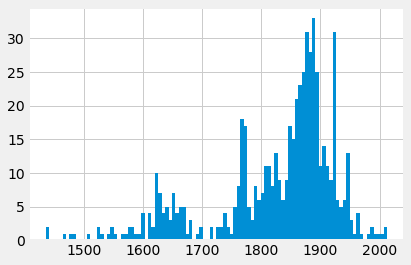

In [424]:
# Photographed paintings creation date (post 1400s)

mask = df_mfa['classifications'].apply(lambda x: 'Paintings' in x)
df1 = df_mfa[mask]
df1[df1['year'] > 1400]['year'].hist(bins=100)

Text(0.5, 0, 'Count (log)')

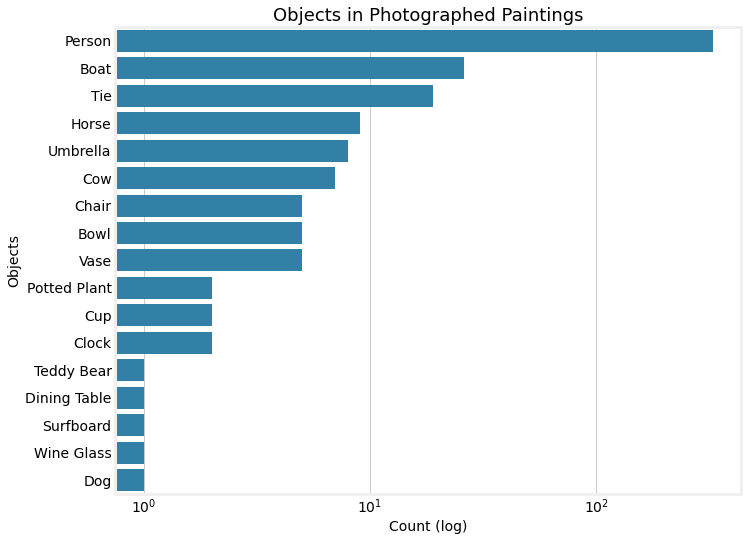

In [430]:
# Most common objects in paintings (top 20)

top_num = 20

mask = df_mfa['classifications'].apply(lambda x: 'Paintings' in x)
df1 = df_mfa[mask]
df_inst = df_instagram[df_instagram.notnull()]
del df_inst['photo_objects']
df_e = df1.explode('instaposts_fullname_80')
df_t = pd.merge(df_e,df_instagram, left_on='instaposts_fullname_80', right_on='id')
df_t = df_t.explode('photo_objects_y')
df_t = pd.DataFrame(df_t.explode('photo_objects_y')['photo_objects_y'].value_counts()[0:top_num]).reset_index()
df_t['index'] = df_t['index'].str.title()

style.use('fivethirtyeight')
plt.figure(figsize=(10, 8), facecolor='white')
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
g = sns.barplot(x="photo_objects_y", y="index", data=df_t, color='#1E86BA')
g.set_xscale("log")
plt.title("Objects in Photographed Paintings", size=18)
plt.ylabel("Objects", size=14)
plt.xlabel("Count (log)", size=14)

Text(0.5, 0, 'Count')

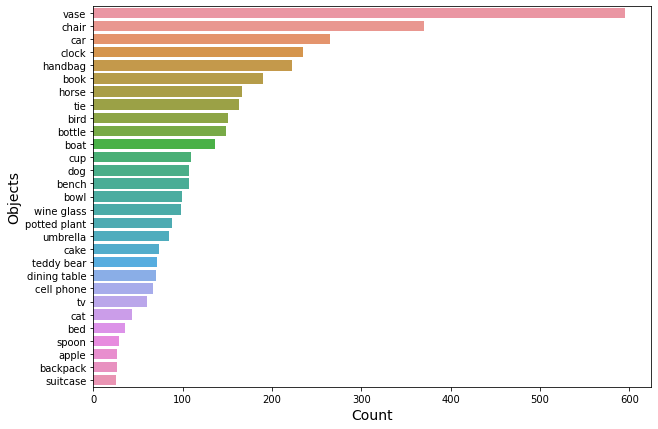

In [57]:
# Most common objects in Instagram photos (top 30, ignoring "person")

top_num = 30

a = pd.DataFrame(df_instagram.explode('photo_objects')['photo_objects'].value_counts()[1:top_num]).reset_index()

plt.figure(figsize=(10,7))
sns.barplot(x="photo_objects", y="index", data=a)
plt.ylabel("Objects", size=14)
plt.xlabel("Count", size=14)

,index,photo_objects
0,vase,595
1,chair,370
2,car,265
3,clock,235
4,handbag,223
5,book,190
6,horse,166
7,tie,163
8,bird,151
9,bottle,149


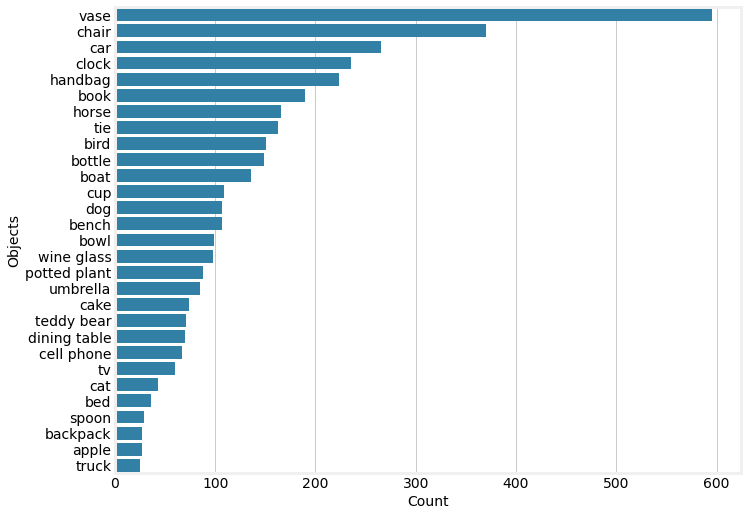

In [260]:
# Most common objects in paintings (top 30, ignoring "person")

top_num = 30

a = pd.DataFrame(df_instagram.explode('photo_objects')['photo_objects'].value_counts()[1:top_num]).reset_index()
style.use('fivethirtyeight')
plt.figure(figsize=(10, 8), facecolor='white')
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
sns.barplot(x="photo_objects", y="index", data=a, color='#1E86BA')
plt.ylabel("Objects", size=14)
plt.xlabel("Count", size=14)

In [168]:
# Experimental: Group works by hue

# TODO: Find Stackoverflow post this function is from
def HSV_2_RGB(HSV):
    ''' Converts an integer HSV tuple (value range from 0 to 255) to an RGB tuple '''
    H, S, V = HSV
    if S == 0:
        R = V
        G = V
        B = V
        return (R, G, B)
    region = H // 43;
    remainder = (H - (region * 43)) * 6; 
    P = (V * (255 - S)) >> 8;
    Q = (V * (255 - ((S * remainder) >> 8))) >> 8;
    T = (V * (255 - ((S * (255 - remainder)) >> 8))) >> 8;
    if region == 0:
        R = V
        G = T
        B = P
    elif region == 1:
        R = Q; 
        G = V; 
        B = P;
    elif region == 2:
        R = P; 
        G = V; 
        B = T;
    elif region == 3:
        R = P; 
        G = Q; 
        B = V;
    elif region == 4:
        R = T; 
        G = P; 
        B = V;
    else: 
        R = V; 
        G = P; 
        B = Q;


    return (R, G, B)

df_instagram['photo_color_hue'] = df_instagram['photo_color'].apply(lambda c: matplotlib.colors.to_rgb(c) if c else None)
df_instagram['photo_color_hue'] = df_instagram['photo_color_hue'].apply(lambda c: round(colorsys.rgb_to_hsv(c[0],c[1],c[2])[0],2) if c else None)

df_colors = pd.DataFrame(df_instagram['photo_color_hue'].value_counts()).reset_index()
df_colors['color_rgb'] = df_colors['index'].apply(lambda c: HSV_2_RGB((int(c*255),255,255)))
df_colors['color_hsv'] = df_colors['index'].apply(lambda c: Color(hsv=(int(c*255), 1, 1)))
df_colors['color'] = df_colors['color_hsv'].apply(lambda c: c.hex)

els = []
def show(color):
    els.append(f'<div style="width:100px; height:100px; background: {color}; display:inline-block">{color}</div>')

df_colors['color'].apply(show)
display(HTML(f"<div style=\"display:inline; width:800px\">{''.join(els)}</div>"))

In [76]:
df_tagged = df_mfa[df_mfa['instaposts_fullname_80'].str.len() > 0]

,clean_name,total,type
0,John Singer Sargent,51,works
2,John Singleton Copley,35,works
3,Claude Monet,33,works
6,"Paul Revere, Jr.",24,works
50,Jean-François Millet,6,works
54,Paul Gauguin,5,works
103,Vincent Van Gogh,4,works
86,Georgia O'Keeffe,4,works
94,Henri Matisse,4,works
105,Tiffany & Co.,3,works


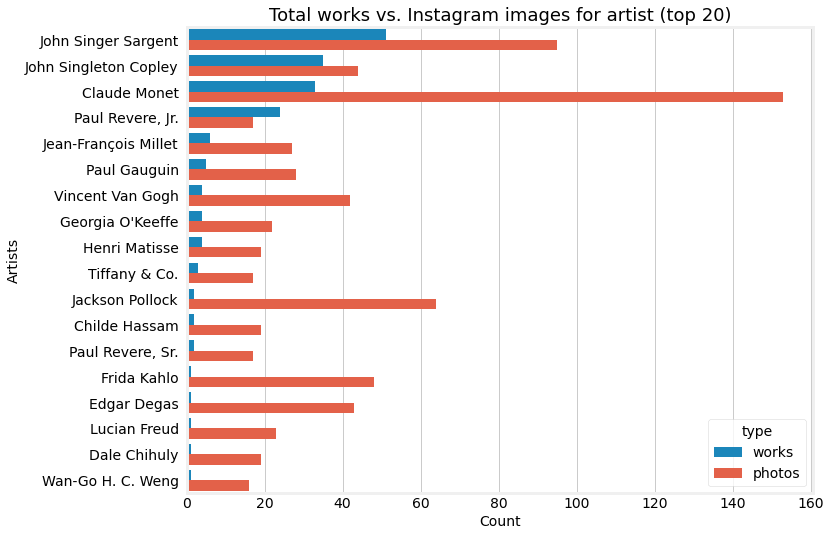

In [244]:
# Number of works vs Instagram posts by collection

top_num = 20

df_mfa['photo_count'] = df_mfa['instaposts_fullname_80'].apply(lambda x: len(x))
totals = pd.DataFrame(df_mfa[['clean_name','photo_count']].value_counts()).reset_index()
totals = totals.rename(columns={0: 'total_works'}).sort_values(by='photo_count',ascending=False)[:top_num]

total_photos = totals[['clean_name','photo_count']]
total_photos = total_photos.rename(columns={'photo_count': 'total'})
total_photos['type'] = 'photos'
total_photos
total_works = totals[['clean_name','total_works']]
total_works = total_works.rename(columns={'total_works': 'total'})
total_works['type'] = 'works'

things = pd.concat([total_photos,total_works])
things = things[things['clean_name'] != 'm']
things = things[things['clean_name'] != 'ha'].sort_values(by=['type','total'], ascending=False)
things['clean_name'] = things['clean_name'].str.title()

plt.figure(figsize=(10, 8), facecolor='white')
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

sns.barplot(x="total", 
            y="clean_name", 
            hue="type", 
            data=things, 
            errwidth = 0.0)
# g.set_xscale("log")

plt.ylabel("Artists", size=14)
plt.xlabel("Count", size=14)
plt.title("Total works vs. Instagram images for artist (top 20)", size=18)
plt.savefig("grouped_barplot_Seaborn_barplot_Python.png")
things

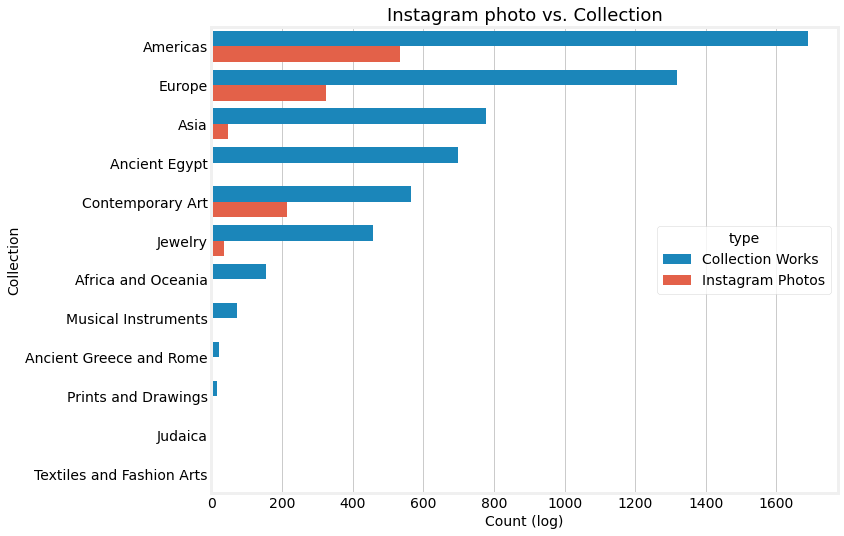

In [94]:
# Number of works vs Instagram posts by collection

df_a = df_tagged.explode('collectionTerms')
df_b = df_mfa.explode('collectionTerms')
a = pd.DataFrame(df_a['collectionTerms'].value_counts())
b = pd.DataFrame(df_b['collectionTerms'].value_counts())
a = pd.DataFrame(df_a['primary_collection'].value_counts())
b = pd.DataFrame(df_b['primary_collection'].value_counts())
a = a.reset_index()
a['type'] = 'Instagram Photos'
a['index']  = a['index'].str.lstrip()
b = b.reset_index()
b['type'] = 'Collection Works'
b['index']  = b['index'].str.lstrip()
areas = pd.concat([a,b])
areas = areas.rename(columns={'primary_collection': 'work_count'})
areas = areas.sort_values('work_count', ascending=False)

style.use('fivethirtyeight')
plt.figure(figsize=(10, 8), facecolor='white')
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
sns.barplot(x="work_count", 
            y="index", 
            hue="type", 
            data=areas, 
            errwidth = 0.0)
g.set_xscale("log")
plt.ylabel("Collection", size=14)
plt.xlabel("Count (log)", size=14)
plt.title("Instagram photo vs. Collection", size=18)
plt.savefig("grouped_barplot_Seaborn_barplot_Python.png")

In [106]:
# FIXME

# Create this dataframe making a new row for each elemnt in the collection list
df_a = df_tagged
df_b = df_mfa
a = pd.DataFrame(df_a['onview'].value_counts())
b = pd.DataFrame(df_b['onview'].value_counts())
a = a[a['onview'] > ]
b = b[b['onview'] > 30]
a = a.reset_index()
a['type'] = 'visitor'
a['index']  = a['index'].str.lstrip()
b = b.reset_index()
b['type'] = 'mueum'
b['index']  = b['index'].str.lstrip()
areas = pd.concat([a,b])

areas = areas.rename(columns={'onview': 'work_count'})

plt.figure(figsize=(12,50))
g = sns.barplot(x="work_count", 
            y="index", 
            hue="type", 
            data=areas , 
            errwidth = 0.0)
# g.set_xscale("log")

plt.ylabel("M\", size=14)
plt.xlabel("E\", size=14)
plt.title("G\", size=18)
plt.savefig("grouped_barplot_Seaborn_barplot_Python.png")

SyntaxError: invalid syntax (<ipython-input-106-6c394885d104>, line 6)

In [688]:
# Number of works by Gallery name

areas.apply(lambda r: r if r['work_count'] > 20 and r['type'] == 'visitor' else None, axis=1)

,index,work_count,type
0,Alan and Simone Hartman Galleries (Gallery 241),55.0,visitor
1,Penny and Jeff Vinik Gallery (Gallery 233),51.0,visitor
2,Angelica Lloyd Russell Gallery (Gallery 142),34.0,visitor
3,Robert P. and Carol T. Henderson Gallery (Gallery 228),32.0,visitor
4,The 1940s and 1950s Gallery (Gallery 336),31.0,visitor
...,...,...,...
144,None,NaN,None
145,None,NaN,None
146,None,NaN,None
147,None,NaN,None


In [229]:
# Show all matched Instagram posts (inline)

df_grouped = df_mfa.groupby('clean_name').agg({'instaposts_fullname_80': 'sum'}).reset_index()
df_grouped['instaposts_fullname_80'] = df_grouped['instaposts_fullname_80'].apply(lambda x: [str((s)) for s in list(set(x))])
df_grouped['instaposts_fullname_80']
df_grouped = df_grouped[df_grouped['clean_name'] != 'm'] #don't ask

df_test = df_grouped.explode('instaposts_fullname_80')
df_instagram['id'] = df_instagram['id'].astype(str)
df_instagram['id'] = df_instagram['id'].astype(str)
df_test['instaposts_fullname_80'] = df_test['instaposts_fullname_80'].astype(str)

images = []
output = []

def printy(row):
    global output
    the_id = row['instaposts_fullname_80'].lstrip().rstrip()
    the_name = row['clean_name'].lstrip() if row['clean_name'] else None
    df_instagram_temp = df_instagram[~df_instagram['id'].isin(['2443766684216227840' , '2468240716785932288', '2519193604305205248', '2443223434310818816', '2507781607335939584', '2417979838454675968','2401976719088512512', '2515759434565987328', '2416462299900525568', '2407685634054934016'])]
    image = df_instagram_temp[df_instagram_temp['id'].str.contains(the_id)]
    if len(list(image.display_url)) > 0:
        output.append(f'<span style="float:left"><img style="width:150px" src="{list(image.display_url)[0]}"><span>{the_name} {image.id}</span></span>')
        #display(Image(url= list(image.display_url)[0],width=240))

df_test.apply(printy, axis=1)
display(HTML(' '.join(output)))

In [ ]:
# Heatmap of work dates across galleries

df_test = df_mfa[df_mfa['year'].notnull()]
df_test['year'] = df_test['year'].apply(lambda d: d[0] if d else None)
df_test = df_test[df_test['year'].notnull()]
df_test['round_year'] = df_test['year'].apply(lambda x: int(math.ceil(x / 100.0)) * 100)

df_demo = df_test[['onview','round_year']].copy()
df_demo['onview'] = df_test['onview'].apply(lambda x: x[0] if x else None)
df_demo['view_amount'] = df_demo['onview'].groupby(df_demo['onview']).transform('count')

plt.figure(figsize=(40,18))
df_demo = df_demo[df_demo['view_amount'] > 30]
df_demo = df_demo.sort_values('view_amount', ascending=False)
df_heatmap = df_demo.pivot_table(values='view_amount',index='onview',columns='round_year',aggfunc=np.mean)

with sns.plotting_context(font_scale=5.5):
    g = sns.heatmap(df_heatmap,square=True, cmap='viridis')
    g.set_xticklabels(g.get_xticklabels(), rotation=270)
    plt.title(f"Works in galleries by century")
    plt.xlabel("Century")
    plt.ylabel("Location")

    #set parameters for tick labels
    plt.tick_params(axis='x', which='major', labelsize=18)
    plt.tick_params(axis='y', which='major', labelsize=18)
    
    plt.tight_layout()

30982


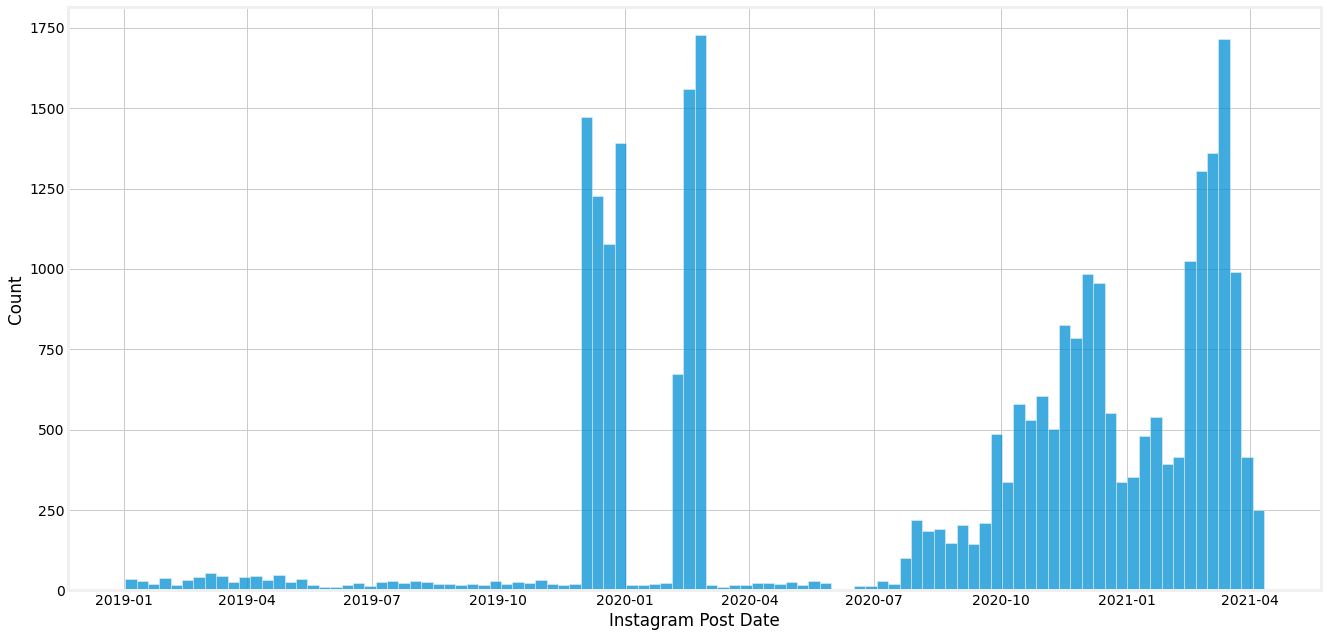

In [98]:
# Collected Instagram post dates

mypath = '../images/mfaboston-complete/'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
onlyfiles = [f for f in onlyfiles if f.split('.')[-1] == 'jpg']
onlyfiles = [f.split('_')[0] for f in onlyfiles]
onlyfiles = [{'Instagram Post Date':(datetime.datetime.fromisoformat(f))} for f in onlyfiles]
onlyfiles = pd.DataFrame(onlyfiles)#.hist(bins=100)
print(len(onlyfiles))
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.figure(figsize=(20, 10), facecolor='white')
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
onlyfiles['Instagram Post Date'] = onlyfiles['Instagram Post Date'].astype('datetime64[ns]')
onlyfiles = onlyfiles[(onlyfiles['Instagram Post Date']> "2019-01-01") & (onlyfiles['Instagram Post Date']< "2021-04-14")]#.hist(figsize=(20, 10), bins=100)
sns.histplot(data=onlyfiles, x="Instagram Post Date", bins=100)

plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.show()

In [2]:
## Years mentioned Instagram posts

def get_years(text):
    words = text.split(' ')
    numbers = [word for word in words if word.isdigit() and len(word) > 3]
    return numbers
plt.figure(figsize=(10, 8), facecolor='white')

df_years = df_instagram
df_years['years'] = df_years['text'].apply(get_years)
df_years = df_years.explode('years')
df_years = df_years[df_years['years'].notnull()]
df_years['years'] = df_years['years'].astype(int)
df_years['years'] = df_years['years'].apply(lambda y: -y if y > 2021 else y)
df_years['years'] = df_years['years'].apply(lambda y: y if y > 0 else None)
df_years = df_years[df_years['years'].notnull()]
plt.title("Year of work in post (A.D.)", size=18)
plt.ylabel("Count", size=14)
plt.xlabel("Year", size=14)
sns.histplot(data=df_years, x="years", bins=100)
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.show()

df_years = df_instagram
df_years['years'] = df_years['text'].apply(get_years)
df_years = df_years.explode('years')
df_years = df_years[df_years['years'].notnull()]
df_years['years'] = df_years['years'].astype(int)
df_years['years'] = df_years['years'].apply(lambda y: -y if y > 2021 else y)
df_years['years'] = df_years['years'].apply(lambda y: y if y < 0 and y > -4000 else None)
df_years = df_years[df_years['years'].notnull()]

plt.figure(figsize=(10, 8), facecolor='white')
plt.set_xscale("log")
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
sns.histplot(data=df_years, x="years", bins=100)
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.ylabel("Count", size=14)
plt.xlabel("Year", size=14)
plt.title("Year of work in post (B.C.)", size=18)
plt.savefig("grouped_barplot_Seaborn_barplot_Python.png")
plt.show()
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

NameError: name 'plt' is not defined

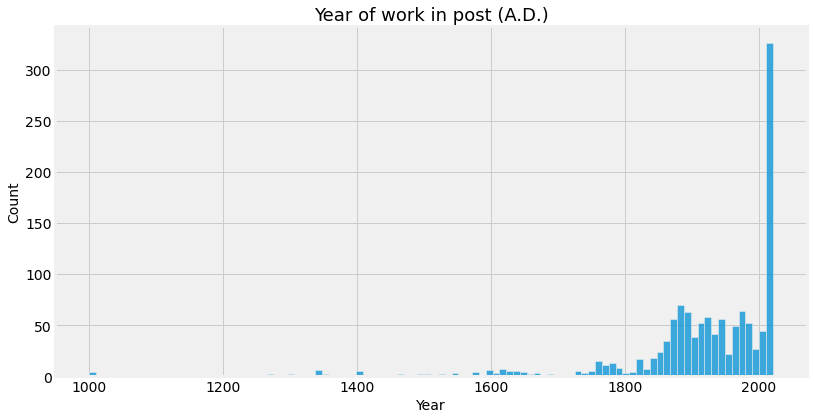

In [103]:
## Years mentioned Instagram posts

style.use('fivethirtyeight')
def get_years(text):
    words = text.split(' ')
    numbers = [word for word in words if word.isdigit() and len(word) > 3]
    return numbers
plt.figure(figsize=(12, 6), facecolor='white')

df_years = df_instagram
df_years['years'] = df_years['text'].apply(get_years)

df_years = df_years.explode('years')
df_years = df_years[df_years['years'].notnull()]
df_years['years'] = df_years['years'].astype(int)
df_years['years'] = df_years['years'].apply(lambda y: -y if y > 2021 else y)
df_years['years'] = df_years['years'].apply(lambda y: y if y > 0 else None)
df_years = df_years[df_years['years'].notnull()]

plt.title("Year of work in post (A.D.)", size=18)
plt.ylabel("Count", size=14)
plt.xlabel("Year", size=14)
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
g = sns.histplot(data=df_years, x="years", bins=100)
g.set_yscale("linear")
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.show()

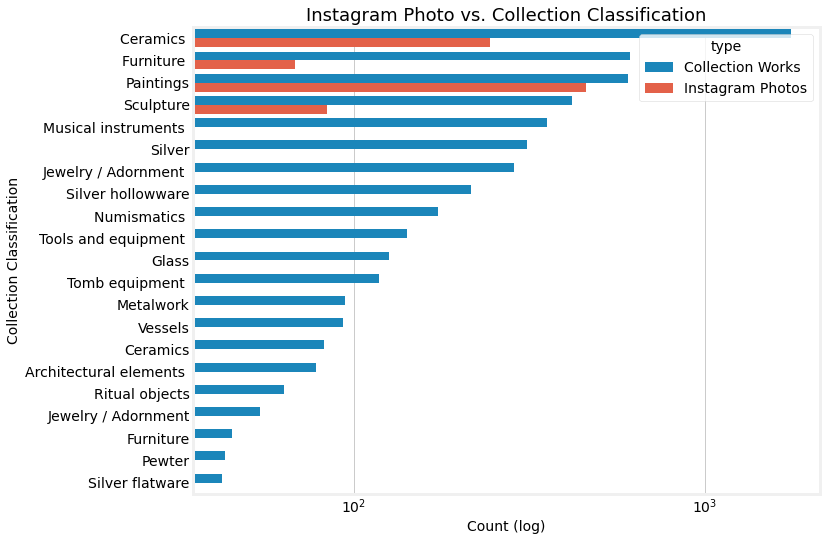

In [96]:
# Number of works vs Instagram posts by medium


df_mfa[df_mfa['instaposts_fullname_80'].str.len() != 0]['classifications'].value_counts()
df_mfa['primary_classification'] = df_mfa['classifications'].apply(lambda c: c[0])
style.use('fivethirtyeight')
# Create this dataframe making a new row for each elemnt in the collection list
df_a = df_tagged.explode('classifications')
df_b = df_mfa.explode('classifications')
a = pd.DataFrame(df_a['classifications'].value_counts())
b = pd.DataFrame(df_b['classifications'].value_counts())
a = pd.DataFrame(df_a['primary_classification'].value_counts())
b = pd.DataFrame(df_b['primary_classification'].value_counts())
a = a.reset_index()
a['type'] = 'Instagram Photos'
a['index']  = a['index'].str.lstrip()
b = b.reset_index()
b['type'] = 'Collection Works'
b['index']  = b['index'].str.lstrip()
areas = pd.concat([a,b])

areas = areas.rename(columns={'primary_classification': 'work_count'})
areas = areas.sort_values('work_count', ascending=False)
areas = areas[:25]
plt.figure(figsize=(10, 8), facecolor='white')
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

g = sns.barplot(x="work_count", 
            y="index", 
            hue="type", 
            data=areas, 
            errwidth = 0.0)
g.set_xscale("log")


plt.ylabel("Collection Classification", size=14)
plt.xlabel("Count (log)", size=14)
plt.title("Instagram Photo vs. Collection Classification", size=18)
plt.savefig("grouped_barplot_Seaborn_barplot_Python.png")

"\nwhat makes a good proje3ct \nimpact uniquenss magic\nwhat is acompelling idea that if taken to scale can make impact\ndoesn't like incremental project (optimziation)\nbut not so big you can't finish\nhe likes ideas that go into a new direction in an exciting way\ni.e. various issues iwht bike sharign\n"

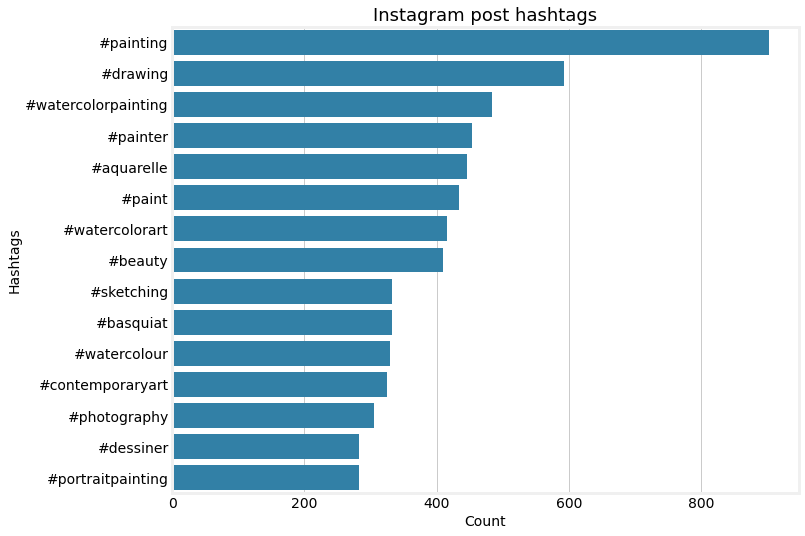

In [77]:
# Most common Instagram post hashtags

# ignore tags that aren't useful
filter_tags = ['#mfaboston', '#art','#boston', '#mfa','#artistsoninstagram','#instaart','#heartart','#mfabostonstudio','#museum','#beautiful','#tableaux','#portraits','#artist','#paintersofinstagram','#museumoffinearts','#artistsforpeace','#artwork','#arthistory','#artislife','#museumoffineartsboston']

df_hashtags = df_instagram.explode('hashtags')
df_hashtags['hashtags'] = df_hashtags['hashtags'].str.lower()
hashtags = pd.DataFrame(df_hashtags['hashtags'].value_counts())
hashtags = hashtags.head(75)
hashtags = hashtags.reset_index()
hashtags = hashtags.rename(columns={'index': 'tag'})
hashtags = hashtags[~hashtags['tag'].isin(filter_tags)]
plt.figure(figsize=(10, 8), facecolor='white')
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

sns.barplot(x="hashtags", y="tag", data=hashtags.head(15), color='#1E86BA')
plt.ylabel("Hashtags", size=14)
plt.xlabel("Count", size=14) 
plt.title("Instagram post hashtags", size=18)

## Get all periods/ collections associated with artists in Instagram posts

,date_bucket,photo_objects_x
0,0,cup
1,1340,bird
2,1380,clock
3,1580,bottle
4,1600,horse
5,1620,dog
6,1630,dog
7,1650,horse
8,1660,boat
9,1680,horse


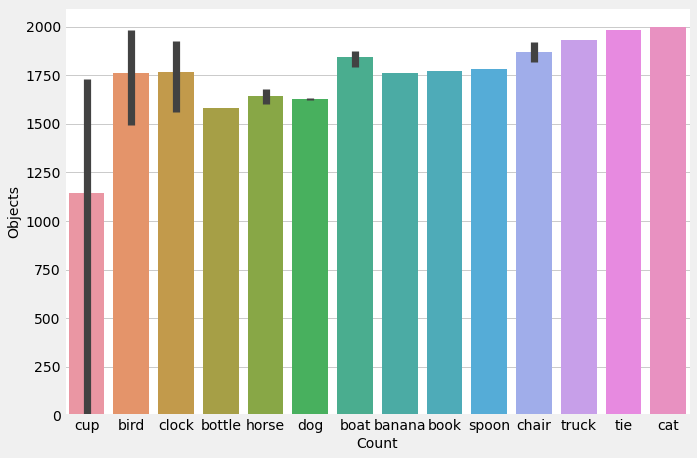

In [221]:
# Most common object in work by decade

df_mfa['year'] = df_mfa['year'].fillna(0.0).astype('Int32')
df_mfa['date_bucket'] = df_mfa['year'].apply(lambda y: round(y, -1))
df_e = df_mfa.explode('instaposts_fullname_80')
df_t = pd.merge(df_e,df_instagram, left_on='instaposts_fullname_80', right_on='id')
df_t = df_t.explode('photo_objects_x')
df_t = df_t[(df_t['photo_objects_x'].notnull()) & (df_t['photo_objects_x'] != 'person') & (df_t['photo_objects_x'] != 'vase') & (df_t['photo_objects_x'] != 'snowboard') & (df_t['photo_objects_x'] != 'bicycle')]  
df_t = df_t.groupby(['date_bucket'])['photo_objects_x'].agg(lambda x:x.value_counts().index[0]).reset_index()
df_t

plt.figure(figsize=(10,7))
sns.barplot(x="photo_objects_x", y="date_bucket", data=df_t)
plt.ylabel("Objects", size=14)
plt.xlabel("Count", size=14)
df_t

/Users/justinblinder/dev/anaconda3/envs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/justinblinder/dev/anaconda3/envs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


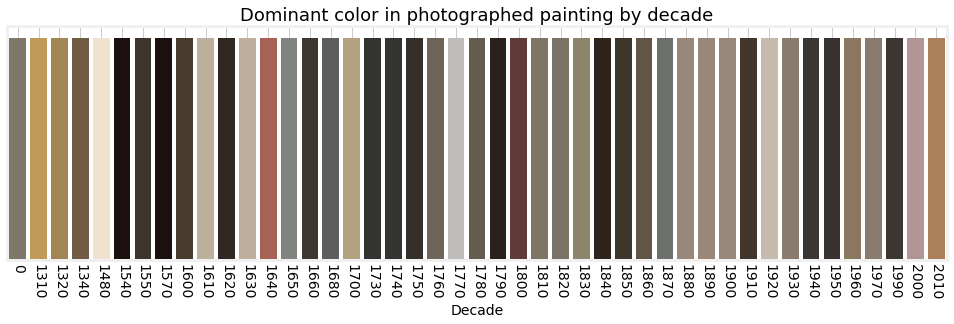

In [431]:
# Most common color in painting by decade 

mask = df_mfa['classifications'].apply(lambda x: 'Paintings' in x)
df_p = df_mfa[mask]
df_p['year'] = df_p['year'].fillna(0.0).astype('Int32')
df_p['date_bucket'] = df_p['year'].apply(lambda y: round(y, -1))
df_e = df_p.explode('instaposts_fullname_80')
df_t = pd.merge(df_e,df_instagram, left_on='instaposts_fullname_80', right_on='id')
df_t = df_t.explode('photo_color')
df_t = df_t[(df_t['photo_color'].notnull())]  
df_t = df_t.groupby(['date_bucket'])['photo_color'].agg(lambda x:x.value_counts().index[0]).reset_index()
df_t['value'] = 1

colors = list(df_t['photo_color'])
plt.figure(figsize=(15, 4), facecolor='white')
sns.set_palette(colors)
sns.barplot(x="date_bucket", y="value", data=df_t)
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.ylabel("", size=14)
plt.xlabel("Decade", size=14)
plt.title("Dominant color in photographed painting by decade", size=18)
plt.xticks(rotation=270)
plt.tick_params(top=False, bottom=True, left=False, right=False,
                labelleft=False, labelbottom=True)
plt.grid(b=None)

# Utilities

In [138]:
# saved matched image urls (for other image processing tasks)
image_urls = [list(i) for i in images]
image_urls= [f'{item.split(".")[0]}.jpg' for sublist in image_urls for item in sublist]

with open('matched_image_urls.pkl', 'wb') as f:
    pickle.dump(image_urls, f)
image_urls

['2021-01-14_18-33-06_UTC.jpg',
 '2020-05-09_21-00-50_UTC.jpg',
 '2021-03-03_17-08-48_UTC.jpg',
 '2019-12-07_18-22-26_UTC.jpg',
 '2017-11-06_17-01-32_UTC.jpg',
 '2021-03-11_01-28-41_UTC.jpg',
 '2017-09-17_20-22-26_UTC.jpg',
 '2017-07-14_16-35-25_UTC.jpg',
 '2020-01-27_18-00-11_UTC.jpg',
 '2020-08-02_21-02-22_UTC.jpg',
 '2020-11-30_14-48-41_UTC.jpg',
 '2021-03-02_21-22-59_UTC.jpg',
 '2020-09-08_14-08-17_UTC.jpg',
 '2018-03-21_16-00-01_UTC.jpg',
 '2020-12-06_19-42-45_UTC.jpg',
 '2020-09-08_14-25-46_UTC.jpg',
 '2020-09-02_15-55-42_UTC.jpg',
 '2020-12-22_10-29-50_UTC.jpg',
 '2018-01-07_13-10-27_UTC.jpg',
 '2021-03-19_06-00-39_UTC.jpg',
 '2020-02-10_23-28-58_UTC.jpg',
 '2018-06-04_14-07-25_UTC.jpg',
 '2020-11-30_15-09-36_UTC.jpg',
 '2020-10-16_18-48-33_UTC.jpg',
 '2018-02-28_12-03-11_UTC.jpg',
 '2020-10-16_18-48-36_UTC.jpg',
 '2016-10-29_12-29-43_UTC.jpg',
 '2020-02-20_20-59-42_UTC.jpg',
 '2021-03-07_21-40-35_UTC.jpg',
 '2021-03-06_13-44-54_UTC.jpg',
 '2021-03-06_13-44-52_UTC.jpg',
 '2017-0

In [217]:
# copy queried Instagram images to directory (used for other image processing tasks)

def get_image(i_id):
    matches = df_instagram[df_instagram['id'].str.contains(i_id.lstrip())]['filename']
    matches = [match for match in matches if match]
    if(len(matches)) == 0:
        return None
    return list(matches)[0]
    
df_monet = df_mfa[df_mfa['clean_name'].str.contains('claude monet',na=False)].explode('instaposts_fullname_80')
df_monet = df_monet.drop_duplicates(subset=['instaposts_fullname_80'])
df_monet['filename'] = df_monet['instaposts_fullname_80'].apply(get_image)
df_monet['filename'] = df_monet['filename'].str.split('.')

monet_instagram_ids = df_mfa[df_mfa['clean_name'].str.contains('monet',na=False)].head(1).explode('instaposts_fullname_80')['instaposts_fullname_80']
monet_instagram_ids = monet_instagram_ids.str.lstrip()
monet_instagram_ids = list(monet_instagram_ids)
monet_instagram_files = df_instagram[df_instagram['id'].isin(monet_instagram_ids)]['filename']
monet_instagram_files = list(monet_instagram_urls)
monet_filenames = [file.split('.')[0] for file in monet_instagram_files]
image_filenames = os.listdir('../images/mfaboston-complete')
image_filenames = [image_path for image_path in image_filenames if image_path in image_filenames]

matching = []
for s in monet_filenames:
    matching.append([file for file in image_filenames if s in file])
matching = [item for sublist in matching for item in sublist]
for match in matching:
    copyfile(f'../images/mfaboston-complete/{match}',f'../images/mfaboston-monet/{match}')


[['2018-11-14_13-12-36_UTC.json.xz',
  '2018-11-14_13-12-36_UTC_8.jpg',
  '2018-11-14_13-12-36_UTC_9.jpg',
  '2018-11-14_13-12-36_UTC_10.jpg',
  '2018-11-14_13-12-36_UTC_2.jpg',
  '2018-11-14_13-12-36_UTC_3.jpg',
  '2018-11-14_13-12-36_UTC_1.jpg',
  '2018-11-14_13-12-36_UTC_4.jpg',
  '2018-11-14_13-12-36_UTC_5.jpg',
  '2018-11-14_13-12-36_UTC_7.jpg',
  '2018-11-14_13-12-36_UTC_6.jpg'],
 ['2020-02-13_17-42-23_UTC.json.xz', '2020-02-13_17-42-23_UTC.jpg'],
 ['2019-12-28_16-32-57_UTC.json.xz', '2019-12-28_16-32-57_UTC.jpg'],
 ['2019-01-29_12-00-01_UTC.json.xz', '2019-01-29_12-00-01_UTC.jpg'],
 ['2020-10-21_20-26-58_UTC.json.xz', '2020-10-21_20-26-58_UTC.jpg'],
 ['2020-05-20_02-47-27_UTC.json.xz',
  '2020-05-20_02-47-27_UTC_1.jpg',
  '2020-05-20_02-47-27_UTC_2.jpg'],
 ['2021-03-14_16-30-18_UTC.json.xz', '2021-03-14_16-30-18_UTC.jpg'],
 ['2020-11-15_00-05-34_UTC_2.jpg',
  '2020-11-15_00-05-34_UTC_3.jpg',
  '2020-11-15_00-05-34_UTC.json.xz',
  '2020-11-15_00-05-34_UTC_1.jpg',
  '2020-11-15_00

In [58]:
# save MFA images to disk
images = list(df_mfa.explode('image_ids')['image_ids'])
for image in images:
    url = "https://collections.mfa.org/internal/media/dispatcher/735365/preview"
    response = requests.get(url)
    if response.status_code == 200:
        with open(f'collection-works/{image}.jpg', 'wb') as f:
            f.write(response.content)

,text,date,filename,id,shortcode,comments_count,comments_disabled,taken_at_timestamp,width,height,display_url,preview_liked_count,user_id,thumbnail_url,is_video,liked_count,hashtags,text_nohastags,photo_objects
0,"#Renaissance painter Fra Filippo Lippi inspired his star student #Botticelli with majestic, intimate depictions of the Virgin and Child. The back of this panel on view in “Botticelli and the Search for the Divine” reveals rare examples of Lippi’s draftsmanship. #mfaBotticelliPictured: “Virgin and Child,” about 1466–69, on loan from Palazzo Medici Riccardi, Florence.",2017-05-16 19:54:12,2017-05-16_19-54-12_UTC.json.xz,1516194176857228288,BUKmpIaF0Pw,25.0,0.0,1.494964e+09,750.0,937.0,https://scontent-lga3-1.cdninstagram.com/v/t51.2885-15/e15/18579634_1498608166850166_6721549137348657152_n.jpg?tp=1&_nc_ht=scontent-lga3-1.cdninstagram.com&_nc_cat=106&_nc_ohc=pvDA28gn6qIAX96sJ_z&edm=APU89FAAAAAA&ccb=7-4&oh=a8221b730dc000389a005bf950484ec8&oe=606EF7DF&_nc_sid=86f79a,1547.0,2.375566e+08,https://scontent-lga3-1.cdninstagram.com/v/t51.2885-15/e15/c0.90.720.720a/s640x640/18579634_1498608166850166_6721549137348657152_n.jpg?tp=1&_nc_ht=scontent-lga3-1.cdninstagram.com&_nc_cat=106&_nc_ohc=pvDA28gn6qIAX96sJ_z&edm=APU89FAAAAAA&ccb=7-4&oh=fa9457bcdfe6e53c3ec3ddbc80f48540&oe=606EB5A4&_nc_sid=86f79a,1.0,NaN,"[#Renaissance, #Botticelli, #mfaBotticelliPictured:]","painter Fra Filippo Lippi inspired his star student with majestic, intimate depictions of the Virgin and Child. The back of this panel on view in “Botticelli and the Search for the Divine” reveals rare examples of Lippi’s draftsmanship. “Virgin and Child,” about 1466–69, on loan from Palazzo Medici Riccardi, Florence.",None
1,Enti 🌹🥀🌹Aquarelle 🖤 2021.Arches 10×14 140 lb. Cold Press.Watercolor with coffee and rose hookah tobacco.أُحِبُّكِ انتِ. 🥀❤🕊#yourdamascenerose 🥀🇸🇾#Syria #SaveSyria 💚🌹❤🌹🖤#Watercolor #Watercolour #Aquarelle #watercolorpainting #WatercolorArt #PaintersOfInstagram #Painting #Painter #Paint #tableaux #Drawing #Sketching #Dessiner #Dessin #ArtistsonInstagram #Art #InstaArt #Portraits #Beauty #Beautiful #SyrianBeauty 🥀🇸🇾 #Femme #ArtistsForPeace #PortraitPainting #MFABoston #MFABostonStudio #HeartArt ❤,2021-02-14 22:36:28,2021-02-14_22-36-28_UTC.json 2.xz,2509218597353401344,CLSiQUXDasc,1.0,0.0,1.613342e+09,1080.0,1334.0,https://scontent-lga3-1.cdninstagram.com/v/t51.2885-15/e35/149974757_888519848644059_3178394119203096874_n.jpg?tp=1&_nc_ht=scontent-lga3-1.cdninstagram.com&_nc_cat=103&_nc_ohc=XQfmNzlHuEwAX928Ghb&ccb=7-4&oh=12d7145a21cc6bd940aa6e8085fa9883&oe=607E2E72&_nc_sid=4efc9f,15.0,1.654959e+09,https://scontent-lga3-1.cdninstagram.com/v/t51.2885-15/sh0.08/e35/c0.127.1080.1080a/s640x640/149974757_888519848644059_3178394119203096874_n.jpg?tp=1&_nc_ht=scontent-lga3-1.cdninstagram.com&_nc_cat=103&_nc_ohc=XQfmNzlHuEwAX928Ghb&ccb=7-4&oh=fbffa3bf1727c1d47dc91eb03f0af778&oe=607E8DE1&_nc_sid=4efc9f,0.0,15.0,"[#SaveSyria, #Watercolour, #Aquarelle, #watercolorpainting, #WatercolorArt, #PaintersOfInstagram, #Painting, #Painter, #Paint, #tableaux, #Drawing, #Sketching, #Dessiner, #Dessin, #ArtistsonInstagram, #Art, #InstaArt, #Portraits, #Beauty, #Beautiful, #SyrianBeauty, #Femme, #ArtistsForPeace, #PortraitPainting, #MFABoston, #MFABostonStudio, #HeartArt]",Enti 🌹🥀🌹Aquarelle 🖤 2021.Arches 10×14 140 lb. Cold Press.Watercolor with coffee and rose hookah tobacco.أُحِبُّكِ انتِ. 🥀❤🕊#yourdamascenerose 🥀🇸🇾#Syria 💚🌹❤🌹🖤#Watercolor 🥀🇸🇾 ❤,None
2,Another day another walk. Is that a horse on my head? #boston #mfaboston,2020-12-22 01:23:50,2020-12-22_01-23-50_UTC.json.xz,2469440177853366272,CJFNsITBv88,0.0,0.0,1.608600e+09,1080.0,1349.0,https://scontent-lga3-1.cdninstagram.com/v/t51.2885-15/e35/p1080x1080/132000987_102222111725331_63948801249395002_n.jpg?tp=1&_nc_ht=scontent-lga3-1.cdninstagram.com&_nc_cat=103&_nc_ohc=j5ZayMWDPi8AX_spMjb&ccb=7-4&oh=cef2d159eb1cf58bb479406f5b9dd788&oe=6084BEBC&_nc_sid=4efc9f,11.0,3.172792e+09,https://scontent-lga3-1.cdninstagram.com/v/t51.2885-15/sh